In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.compat.v1 import reset_default_graph
print(tf.__version__)

2.3.0


In [3]:
clear_session()
reset_default_graph()
# 设置显存自动增长
physical_devices = tf.config.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, enable=True)

In [5]:
tokenizer = Tokenizer()

data = "In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."
corpus: [str] = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [24]:
# 使用滑动窗口切割序列
input_sequences = []
for line in corpus:
    token_list: [int] = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):     # 从1开始因为第一个n_gram_sequence长度为2，一个单词为x，一个单位为y
        n_gram_sequence: [int] = token_list[0:i+1]
        print(tokenizer.sequences_to_texts([n_gram_sequence]))
        input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len: int = max([len(x) for x in input_sequences])
input_sequences: np.ndarray = pad_sequences(
    input_sequences, 
    maxlen=max_sequence_len, 
    padding='pre'
)

# create predictors and label
xs: np.ndarray = input_sequences[:, 0:-1]
labels: np.ndarray = input_sequences[:, -1]
ys: np.ndarray = to_categorical(labels, num_classes=total_words)

['in the']
['in the town']
['in the town of']
['in the town of athy']
['in the town of athy one']
['in the town of athy one jeremy']
['in the town of athy one jeremy lanigan']
['battered away']
['battered away til']
['battered away til he']
['battered away til he hadnt']
['battered away til he hadnt a']
['battered away til he hadnt a pound']
['his father']
['his father died']
['his father died and']
['his father died and made']
['his father died and made him']
['his father died and made him a']
['his father died and made him a man']
['his father died and made him a man again']
['left him']
['left him a']
['left him a farm']
['left him a farm and']
['left him a farm and ten']
['left him a farm and ten acres']
['left him a farm and ten acres of']
['left him a farm and ten acres of ground']
['he gave']
['he gave a']
['he gave a grand']
['he gave a grand party']
['he gave a grand party for']
['he gave a grand party for friends']
['he gave a grand party for friends and']
['he gave a grand p

In [25]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

4
2
66
8
67
68
69
70


In [26]:
print(xs[6])

[ 0  0  0  4  2 66  8 67 68 69]


In [27]:
print(ys[6])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
print(xs[5])
print(ys[5])

[ 0  0  0  0  4  2 66  8 67 68]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [29]:
print(tokenizer.word_index)

{'and': 1, 'the': 2, 'a': 3, 'in': 4, 'all': 5, 'i': 6, 'for': 7, 'of': 8, 'lanigans': 9, 'ball': 10, 'were': 11, 'at': 12, 'to': 13, 'she': 14, 'stepped': 15, 'his': 16, 'girls': 17, 'as': 18, 'they': 19, 'til': 20, 'he': 21, 'again': 22, 'got': 23, 'boys': 24, 'round': 25, 'that': 26, 'her': 27, 'there': 28, 'three': 29, 'weeks': 30, 'up': 31, 'out': 32, 'him': 33, 'was': 34, 'spent': 35, 'learning': 36, 'new': 37, 'steps': 38, 'long': 39, 'away': 40, 'left': 41, 'friends': 42, 'relations': 43, 'when': 44, 'wall': 45, 'myself': 46, 'nice': 47, 'just': 48, 'dancing': 49, 'merry': 50, 'tipped': 51, 'me': 52, 'soon': 53, 'time': 54, 'old': 55, 'their': 56, 'them': 57, 'danced': 58, 'dublin': 59, 'an': 60, 'put': 61, 'leg': 62, 'miss': 63, 'fainted': 64, 'from': 65, 'town': 66, 'athy': 67, 'one': 68, 'jeremy': 69, 'lanigan': 70, 'battered': 71, 'hadnt': 72, 'pound': 73, 'father': 74, 'died': 75, 'made': 76, 'man': 77, 'farm': 78, 'ten': 79, 'acres': 80, 'ground': 81, 'gave': 82, 'grand':

In [31]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=64, name="embedding_1", input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(units=20, return_sequences=False), name="LSTM_2"))
model.add(Dense(units=total_words, activation='softmax', name="dense_3"))
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()
history: History = model.fit(
    x=xs, 
    y=ys, 
    epochs=500, 
    verbose=1,
    workers=-1,
    use_multiprocessing=True
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 64)            16832     
_________________________________________________________________
LSTM_2 (Bidirectional)       (None, 40)                13600     
_________________________________________________________________
dense_3 (Dense)              (None, 263)               10783     
Total params: 41,215
Trainable params: 41,215
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
15/15 [==============================] - 0s 6ms/step - loss: 5.5686 - accuracy: 0.0155
Epoch 2/500
15/15 [==============================] - 0s 5ms/step - loss: 5.5394 - accuracy: 0.0287
Epoch 3/500
15/15 [==============================] - 0s 5ms/step - loss: 5.4688 - accuracy: 0.0243
Epoch 4/500
15/15 [==============================] - 0s 5ms/step - loss: 5.2768 - acc

15/15 [==============================] - 0s 5ms/step - loss: 2.5400 - accuracy: 0.4945
Epoch 76/500
15/15 [==============================] - 0s 5ms/step - loss: 2.5060 - accuracy: 0.5099
Epoch 77/500
15/15 [==============================] - 0s 5ms/step - loss: 2.4909 - accuracy: 0.5166
Epoch 78/500
15/15 [==============================] - 0s 5ms/step - loss: 2.4705 - accuracy: 0.5099
Epoch 79/500
15/15 [==============================] - 0s 5ms/step - loss: 2.4834 - accuracy: 0.5033
Epoch 80/500
15/15 [==============================] - 0s 5ms/step - loss: 2.4665 - accuracy: 0.5077
Epoch 81/500
15/15 [==============================] - 0s 5ms/step - loss: 2.4294 - accuracy: 0.5254
Epoch 82/500
15/15 [==============================] - 0s 5ms/step - loss: 2.3974 - accuracy: 0.5254
Epoch 83/500
15/15 [==============================] - 0s 5ms/step - loss: 2.3759 - accuracy: 0.5320
Epoch 84/500
15/15 [==============================] - 0s 5ms/step - loss: 2.3381 - accuracy: 0.5430
Epoch 85/500


15/15 [==============================] - 0s 5ms/step - loss: 1.1475 - accuracy: 0.8433
Epoch 157/500
15/15 [==============================] - 0s 5ms/step - loss: 1.1376 - accuracy: 0.8389
Epoch 158/500
15/15 [==============================] - 0s 5ms/step - loss: 1.1290 - accuracy: 0.8477
Epoch 159/500
15/15 [==============================] - 0s 5ms/step - loss: 1.1166 - accuracy: 0.8455
Epoch 160/500
15/15 [==============================] - 0s 5ms/step - loss: 1.1041 - accuracy: 0.8477
Epoch 161/500
15/15 [==============================] - 0s 5ms/step - loss: 1.0960 - accuracy: 0.8565
Epoch 162/500
15/15 [==============================] - 0s 5ms/step - loss: 1.0823 - accuracy: 0.8455
Epoch 163/500
15/15 [==============================] - 0s 5ms/step - loss: 1.0708 - accuracy: 0.8499
Epoch 164/500
15/15 [==============================] - 0s 5ms/step - loss: 1.0610 - accuracy: 0.8631
Epoch 165/500
15/15 [==============================] - 0s 5ms/step - loss: 1.0525 - accuracy: 0.8631
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 0.5870 - accuracy: 0.9227
Epoch 238/500
15/15 [==============================] - 0s 5ms/step - loss: 0.6004 - accuracy: 0.9161
Epoch 239/500
15/15 [==============================] - 0s 5ms/step - loss: 0.5971 - accuracy: 0.9205
Epoch 240/500
15/15 [==============================] - 0s 5ms/step - loss: 0.5711 - accuracy: 0.9227
Epoch 241/500
15/15 [==============================] - 0s 5ms/step - loss: 0.5795 - accuracy: 0.9161
Epoch 242/500
15/15 [==============================] - 0s 5ms/step - loss: 0.5673 - accuracy: 0.9227
Epoch 243/500
15/15 [==============================] - 0s 5ms/step - loss: 0.5506 - accuracy: 0.9272
Epoch 244/500
15/15 [==============================] - 0s 5ms/step - loss: 0.5444 - accuracy: 0.9272
Epoch 245/500
15/15 [==============================] - 0s 5ms/step - loss: 0.5242 - accuracy: 0.9360
Epoch 246/500
15/15 [==============================] - 0s 5ms/step - loss: 0.5111 - accuracy: 0.9338
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 0.2809 - accuracy: 0.9536
Epoch 319/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2792 - accuracy: 0.9492
Epoch 320/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2770 - accuracy: 0.9470
Epoch 321/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2756 - accuracy: 0.9536
Epoch 322/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2742 - accuracy: 0.9492
Epoch 323/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2731 - accuracy: 0.9514
Epoch 324/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2700 - accuracy: 0.9536
Epoch 325/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2677 - accuracy: 0.9470
Epoch 326/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2684 - accuracy: 0.9492
Epoch 327/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2668 - accuracy: 0.9536
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 0.1958 - accuracy: 0.9514
Epoch 400/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1932 - accuracy: 0.9492
Epoch 401/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2032 - accuracy: 0.9360
Epoch 402/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1925 - accuracy: 0.9514
Epoch 403/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2009 - accuracy: 0.9492
Epoch 404/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2034 - accuracy: 0.9448
Epoch 405/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2013 - accuracy: 0.9448
Epoch 406/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1964 - accuracy: 0.9470
Epoch 407/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2117 - accuracy: 0.9448
Epoch 408/500
15/15 [==============================] - 0s 5ms/step - loss: 0.2302 - accuracy: 0.9426
Epoc

15/15 [==============================] - 0s 5ms/step - loss: 0.1379 - accuracy: 0.9492
Epoch 481/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1377 - accuracy: 0.9470
Epoch 482/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1371 - accuracy: 0.9492
Epoch 483/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1356 - accuracy: 0.9470
Epoch 484/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1348 - accuracy: 0.9492
Epoch 485/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1342 - accuracy: 0.9470
Epoch 486/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1338 - accuracy: 0.9448
Epoch 487/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1336 - accuracy: 0.9448
Epoch 488/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1327 - accuracy: 0.9470
Epoch 489/500
15/15 [==============================] - 0s 5ms/step - loss: 0.1332 - accuracy: 0.9514
Epoc

In [33]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

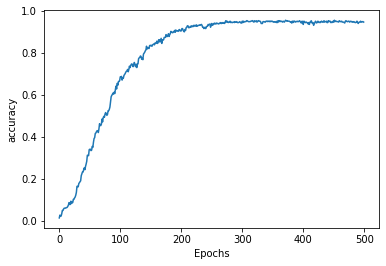

In [34]:
plot_graphs(history, 'accuracy')

In [40]:
seed_text = "Laurence went to dublin"
next_words = 100

reverse_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])
for _ in tqdm(range(next_words)):
    token_list: [int] = tokenizer.texts_to_sequences([seed_text])[0]
    token_list: np.ndarray = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = reverse_index.get(int(predicted), "")
    seed_text += " " + output_word
print(seed_text)

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.46it/s]

Laurence went to dublin the chaneys at lanigans ball ball lanigans ball ball friends and and relations of ground ground of suppose mchugh hearty forget me hearty mad me steps steps give her a call call glisten glisten glisten how me free finnertys hoops call hoops glisten glisten glisten forget new lanigans ball me jig suppose suppose taras lanigans friends her me replied a young terrance of mcgilligan entangled a call call hullabaloo glisten glisten an mchugh call call glisten replied me a call call call replied me a call call call replied call her a call call glisten replied me a call call
